# Using _pykbi_ to analyze radial distribution functions

In this notebook we demonstrate how _pykbi_ can be used to work with radial distribution functions (_rdfs_). Radial distribution functions can be obtained from molecular simulations in various ensembles. Depending on the ensemble they were obtained in, the _rdfs_ will be integrated using either an *open* or *closed* ensemble integration method to obtain Kirkwood-Buff integrals (KBI). 

This notebook will show a potential workflow that can be used to find KBI from a Molecular Dynamics simulation of a three component mixture in the NVT ensemble (constant composition, temperature and volume, a _closed_ system). We will first demonstrate reading in data, and adding it to RDF-objects. Inspecting it, and integrating it using the KBI for closed ensembles. In addition, we have two methods to do finite-size correction of the radial distribution functions, namely the _van der Vegt_ approach and the _Inverse-N_ method. This will be demonstrated later in this document.

In [1]:
# start by importing pykbi and numpy
import pykbi
import numpy as np

## here we print the version
print(pykbi.__version__)

1.0.0


## Importing data and assigning them to RDF objects

Radial distribution functions can be calculated automatically in most modern simulation software. It is usually printed in a text-file, that can be easily parsed in Python. In this example, we will use a rdf calculated from a three component simualation in the NVT ensemble. The interaction potential is for Lennard-Jones particles. The rdfs are printed in a file with the first column being the radial distance, the second column is the 1-1 interaction, the third column is the 2-2 interaction, fourth column is 3-3 interaction, fifth colum is 1-2 interaction, sixth column is 1-3 interaction, and sevent column is the 2-3 interaction. Please note that this ordering and organization of the file is not universal, and different software can organize the data in different ways. Please see the manual of your software to ensure the file is parsed in the correct way.

We start by importing the data, in this case this can easily be done using the _numpy.loadtxt_ function:

In [2]:
rawrdf1 = np.loadtxt("rdf1.txt")
print(rawrdf1.shape)

(700, 7)


Here we see that we have read the file, and added the data to a _numpy.ndarray_, and they have the same number of columns, while the number of rows are difference, due to the different boxsize of the simulations. We will now add these to rdf-objects. We use a notation where the rdf1.txt are stored in rdf objects, and use a subscript with two digits to indicate the interaction type. 

Here we add a list with dictionaries to keep the colors and labels of the different rdfs as well. This can be used later to control the visualisation of the rdfs. 

In [3]:
Lt1 = 14.8245984505
N1 = 1200
N2 = 600
N3 = 600

rdf1_11 = pykbi.rdf.RDF(rawrdf1[:,0], rawrdf1[:,1], closed=True, box_size=Lt1, npart=N1, eqint=True, name="rdf1, 11")
rdf1_22 = pykbi.rdf.RDF(rawrdf1[:,0], rawrdf1[:,2], closed=True, box_size=Lt1, npart=N2, eqint=True, name="rdf1, 22")
rdf1_33 = pykbi.rdf.RDF(rawrdf1[:,0], rawrdf1[:,3], closed=True, box_size=Lt1, npart=N3, eqint=True, name="rdf1, 33")
rdf1_12 = pykbi.rdf.RDF(rawrdf1[:,0], rawrdf1[:,4], closed=True, box_size=Lt1, npart=N1, eqint=False, name="rdf1, 12")
rdf1_13 = pykbi.rdf.RDF(rawrdf1[:,0], rawrdf1[:,5], closed=True, box_size=Lt1, npart=N1, eqint=False, name="rdf1, 13")
rdf1_23 = pykbi.rdf.RDF(rawrdf1[:,0], rawrdf1[:,6], closed=True, box_size=Lt1, npart=N2, eqint=False, name="rdf1, 23")

rdf1_list = [rdf1_11, rdf1_22, rdf1_33, rdf1_12, rdf1_13, rdf1_23]
rdf_visuals = [
    {"color":'#377eb8', "label":"1-1 inter." },
    {"color":'#ff7f00', "label":"2-2 inter." },
    {"color":'#4daf4a', "label":"3-3 inter." },
    {"color":'#f781bf', "label":"1-2 inter." },
    {"color":'#a65628', "label":"1-3 inter." },
    {"color":'#984ea3', "label":"2-3 inter." }
]

There are a few things to notice. The box-size of the system is set using the _box_size_ parameter. For now, we can only do finite-size corrections on cubic boxes, so we will only deal with that geometry. 


On the first three rdfs, we have set the _eqint_ variable to be *True*. This is necessary later when we do finite-size correction. If you don't plan on doing finite-size correction, you can igore this. If it is *True*, it means this rdf was calculated between equal type components, _e.g._ 1-1 or 2-2, while 1-2 and 1-3 interactions have this value set to be *False*. For more information about this, please study the accompaying paper on this type of correction. 

We have set the _npart_ paramter to be N1, N2, and N3 on the first three rdfs. This is the number of particles of this specific type in the the system. For the last three, _npart_ is set to be N1, N1, and N2 respectively. These parameters are only necessary for doing finite-size correction. For the unequal type correction factor, we can choose to use either one of the species being part of the interaction type, or we can use the sum of them. The important thing is that it represents the number of calculated interactions. 

We also set the parameter _closed_ to be *True*. This determines the type of integration, either for open or closed systems. Since these rdfs are obtained in closed systems, we set it to be *True* in this case. 



With the data importend, we can now visualize the rdfs. To do this, we import _matplotlib_. The rdf-objects have a _PlotRDF_-function, that take the axis as argument. Here we show a plot of the 1-1, 2-2, and 3-3 interactions, and in the last figure we have emphasized the last part of the rdf. This is one of the parts we should inspect, to make sure it is converging correctly, and that the rdf is well behaved. Notice: the rdf should approach one in the thermodynamic limit, so for simulations in a finite box it should approach a value of 1-1/N. 


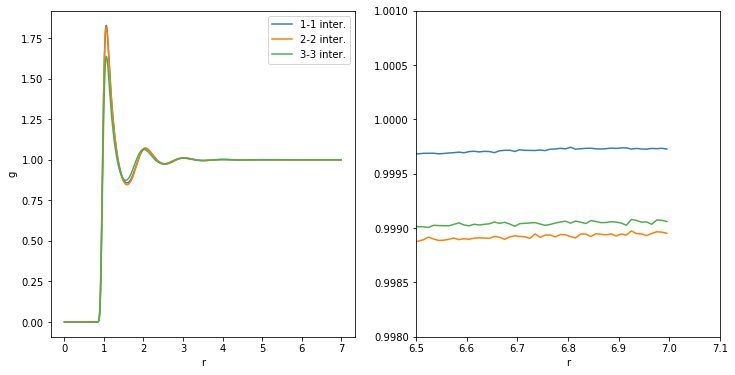

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# since we put the rdfs in a list, we can do this to plot the first three.
for i in range(3):
    rdf1_list[i].PlotRDF(ax1, rdf_visuals[i])
    rdf1_list[i].PlotRDF(ax2, rdf_visuals[i])

ax2.set_xlim((6.5, 7.1))
ax2.set_ylim((0.998, 1.001))
ax1.legend(loc="best")
ax1.set_xlabel("r")
ax2.set_xlabel("r")
ax1.set_ylabel("g")
plt.show()

We see that the radial distribution function has clear finite-size effects. None of the numbers are close to 1 when we are to the rightmost in the figure. The left figure show that the rdf are behaving well, and we have a clear peak in all three lines. This is expected, since the data was sampled from rdfs for LJ particles. These rdfs can now be integrated. Again, we only do this for the first three rdfs, to keep the figures a bit easier to see. 

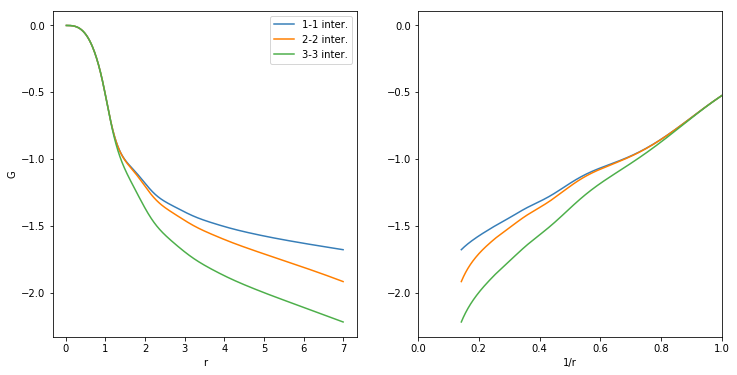

In [5]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

for i in range(3):
    rdf1_list[i].Integrate()
    rdf1_list[i].PlotKBIInverse(ax2, rdf_visuals[i])
    rdf1_list[i].PlotKBI(ax1, rdf_visuals[i])

ax1.set_xlabel("r")
ax2.set_xlabel("1/r")
ax1.set_ylabel("G")
ax1.legend(loc="best")
ax2.set_xlim(0,1.0)
plt.show()

This is the integrated rdf for closed systems. On the left we have the integral showed on a linear scale, while on the right it is plotted on a 1/r-scale. For a closed system, we have to use the right hand figure to extrapolate to the thermodynamic limit to find the true value of G(r). Note that we have to set the x-scale for the right-hand figure to be from 0 to 1, but this can vary depending on your units in the r-vector (notice: we are using reduced units in this case). Choosing the right scale makes it easier to select the right extrapolation limits. 

The data can be extracted from the figure by using the _FindValues_-function. For open systems, we only have to give one value to this function, but for this case, we have to give a range. Please notice this range is given on the 1/r scale, and you should use the right hand figure above to determine where this range is.
Using the _PlotReadout_-function, we plot in the figure the points where the extrapolation range is selected, and the point where the extrapolated value intersects with the $1/r \rightarrow 0$. The interpolation points are shown as circles, and the extrapolated point is shown as a square in the figure below. We shift the x-limit a bit, so it is clear where the intersect points are. 

KBI value for rdf1, 11: -1.8061649084177867
KBI value for rdf1, 22: -1.9696233872529532
KBI value for rdf1, 33: -2.3538182195525095


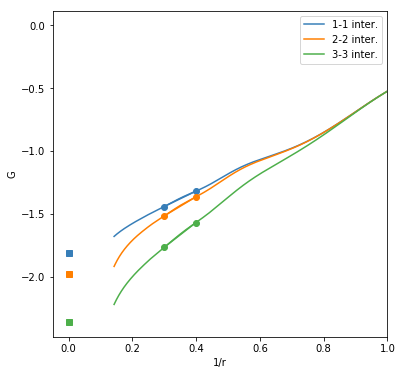

In [6]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1, 1, 1)

## add the data to the figure again. 
for i in range(3):
    rdf1_list[i].PlotKBIInverse(ax1, rdf_visuals[i])

#extrapolate and print the values.
for i in range(3):
    rdf1_list[i].FindValues(position=(0.3,0.40))
    print("KBI value for {}: {}".format(rdf1_list[i].name, rdf1_list[i].ReturnKBI()))
    visual = rdf_visuals[i].copy()
    visual.pop("label")    # we remove the label here, to keep the visual easier
    
    rdf1_list[i].PlotReadout(ax1, visual)

ax1.set_xlim(-0.05,1.0)
ax1.set_xlabel("1/r")
ax1.legend(loc="best")
ax1.set_ylabel("G")
plt.show()    

After the integration, the Kirkwood-Buff coefficient can be obtained using the _ReturnKBI_-function. This function is the same for both open and closed integration methods. 

In the following, we will demonstrate how the finite size correction methods can be used to correct finite-size effects of the rdfs. 

## Finite size corrections

When g(r) is sampled from molecular simulations, they will usually suffer from finite-size effects. pykbi has the possibility to correct for some of these finite size effects. Currently, we have the Inverse N-scaling ([Krüger et al.](dx.doi.org/10.1021/jz301992u)) and the method by [van der Vegt](dx.doi.org/10.1021/ct301017q) implemented. The recommended method is the one from van der Vegt. Here we will demonstrate both of these methods. 


### Finite size correction using the van der Vegt correction method

For more information about the van der Vegt correction method, we refer the reader to the accompanying paper. Instead we will here demonstrate the method directly to correct the rdfs. 

The correction method is called *CorrectVanDerVegt*, and is included in the _pykbi_ package. The function takes a RDF object as the argument and returns a new RDF object where the correlation function has been corrected. To use the correction function, the rdf *must* be initiated using the box_size, npart, and eqint parameters. Below we show the correction for the data we have imported above. Again we focus only on the three first correlations, 1-1, 2-2, and 3-3. 

We first correct them, and then plot them in a figure with the uncorrected version of the rdf. 

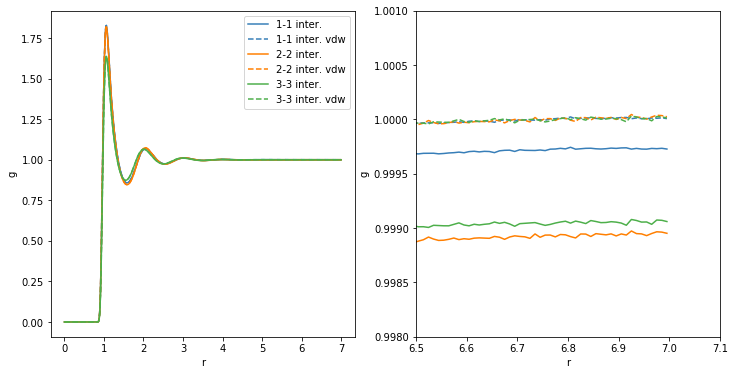

In [7]:
rdf1_11_vdw = pykbi.CorrectVanDerVegt(rdf1_11)
rdf1_22_vdw = pykbi.CorrectVanDerVegt(rdf1_22)
rdf1_33_vdw = pykbi.CorrectVanDerVegt(rdf1_33)

rdf1_list_vdw = [rdf1_11_vdw, rdf1_22_vdw, rdf1_33_vdw]

#make figure
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

#plot values
for i in range(3):
    visual = rdf_visuals[i].copy()
    visual["ls"] = "--"
    visual["label"] += " vdw"
    
    rdf1_list[i].PlotRDF(ax1, rdf_visuals[i])
    rdf1_list_vdw[i].PlotRDF(ax1, visual)
    
    rdf1_list[i].PlotRDF(ax2, rdf_visuals[i])
    rdf1_list_vdw[i].PlotRDF(ax2, visual)

    
ax2.set_xlim((6.5, 7.1))
ax2.set_ylim((0.998, 1.001))

ax1.set_xlabel("r")
ax2.set_xlabel("r")

ax1.legend(loc="best")
ax1.set_ylabel("g")
ax2.set_ylabel("g")
plt.show()    

Here we see the corrected rdfs are almost completely overlaping, and converging much faster to 1. On the figure to the left we see that this is difficult to see on a more normal scale. The difference can be significant after the integration. Next, we will show how this looks when we integrate. We do the integration in the same way as before, and visualise. We plot the integrated rdf using dotted line.

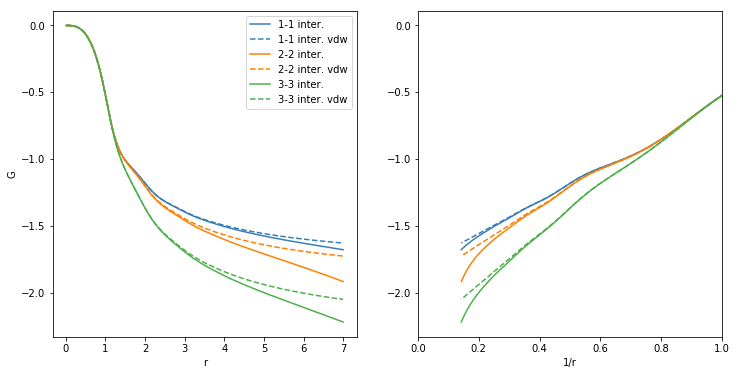

In [8]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

for i in range(3):
    rdf1_list_vdw[i].Integrate()
    visual = rdf_visuals[i].copy()
    visual["ls"] = "--"
    visual["label"] += " vdw"
    
    rdf1_list[i].PlotKBIInverse(ax2, rdf_visuals[i])
    rdf1_list[i].PlotKBI(ax1, rdf_visuals[i])
    rdf1_list_vdw[i].PlotKBIInverse(ax2, visual)
    rdf1_list_vdw[i].PlotKBI(ax1, visual)

ax1.set_xlabel("r")
ax2.set_xlabel("1/r")
ax1.set_ylabel("G")
ax1.legend(loc="best")
ax2.set_xlim(0,1.0)
plt.show()

The linear part of the integral stays linear much longer after the integration. This makes it much easier to identify the linear portion of the integral, and extrapolate to the thermodynamic limit. 

### Finite size correction using the inverse-N method

The inverse-N correction method requires two simulations  in different simulation boxes. These have to have the exact same density. Below we first add a new set of rdfs to the notebook. These are from a simualtion with a smaller box, but with the same density. We add the numbers to list, and iterate over the lists. 


In [9]:
rawrdf2 = np.loadtxt("rdf2.txt")

print(rawrdf2.shape)

Lt2=9.8313208864
N1_2 = 350
N2_2 = 175
N3_2 = 175
Nparts = [N1_2, N2_2, N3_2, N1_2, N1_2, N2_2]
label = ["11", "22", "33", "12", "13", "23"]
eqints = [True, True, True, False, False, False]
rdf2_list = []
for i in range(6):
    rdf2_list.append(pykbi.rdf.RDF(rawrdf2[:,0],rawrdf2[:,i+1],
                                   box_size=Lt2,
                                   closed=True,
                                   npart=Nparts[i],
                                   eqint=eqints[i],
                                   name=("rdf2, "+label[i])
                                  ))



(351, 7)


It is important to note that the inverse-N method will only work up to the lenght of the shortes radial distance we have in the two systems. This means that for the larger system, we have to disregard a portion of the data. In this case, we are comparing to a system that is significantly smaller, so we have to disregard a significant portion of the data. 

We then do the finite-size correction using the function _CorrectInverseN_. In the following we do the correction, and plot the rdf the same way we did above for the van der Vegt correction. In this case we plot the 

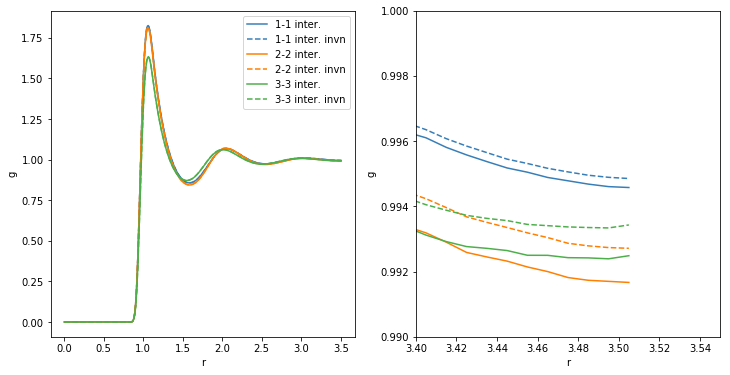

In [10]:
rdf1_11_invn = pykbi.CorrectInverseN(rdf1_11, rdf2_list[0])
rdf1_22_invn = pykbi.CorrectInverseN(rdf1_22, rdf2_list[1])
rdf1_33_invn = pykbi.CorrectInverseN(rdf1_33, rdf2_list[2])

rdf1_list_invn = [rdf1_11_invn, rdf1_22_invn, rdf1_33_invn]

#make figure
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

#plot values
for i in range(3):
    visual = rdf_visuals[i].copy()
    visual["ls"] = "--"
    visual["label"] += " invn"
    
    rdf2_list[i].PlotRDF(ax1, rdf_visuals[i])
    rdf1_list_invn[i].PlotRDF(ax1, visual)
    
    rdf2_list[i].PlotRDF(ax2, rdf_visuals[i])
    rdf1_list_invn[i].PlotRDF(ax2, visual)

    
ax2.set_xlim((3.4, 3.55))
ax2.set_ylim((0.99, 1.00))

ax1.set_xlabel("r")
ax2.set_xlabel("r")

ax1.legend(loc="best")
ax1.set_ylabel("g")
ax2.set_ylabel("g")
plt.show()    

We see that the dashed lines are converging more smoothly to the value of 1 then the other lines, but the effect is less clear here then it was for the van der Vegt correction method. 

The data can be integrated the same way we have demonstrated above. Using the inverse-N correction method, it is always a good idea to compare the results with the longest version of the correction method, and study this directly. The additional data using the uncorrected rdf can some times yield a better result then using the inverse-N correction method. 

## Writing data to file

The RDF-objects can write data to file. This usus the _json_ module. It currently have no option to read these files back in. To do this, we use the function _SaveToJSON", that takes one argument, the filename. If this does not end in .json, the function will append this. For this function to write out data, we have to integrate, and read out data from the intgral. Below we see a sample of how we can do this with the *rdf1_11_invn* object we create above. We only set one of the limit to read out data. 

In [12]:
rdf1_11_invn.Integrate()
rdf1_11_invn.FindValues((None,1.0))
rdf1_11_invn.SaveToJSON("test_output.json")


In [14]:
%cat test_output.json

{
  "G": -1.8411268625845858,
  "slope": 1.3185574377043168,
  "p_value": 0.0,
  "std_error": 0.0,
  "r_value": 1.0,
  "index_limit": [
    99,
    349
  ],
  "value_limit": [
    0.9950248756218911,
    0.28530670470756075
  ],
  "gr": [
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    1.1811994712536678e-08,
    3.1224838

We see the data is stored in a format so it can be easily read by other programs if needed. 